In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16
import keras.backend as K
from tensorflow.keras import callbacks
import tensorflow as tf

from PIL import Image

# Open image file and get the dimensions
img = Image.open('test/Carrot/1001.jpg')
shape = img.size
print(f'Image size: {shape}')
# Define parameters
batch_size = 32
num_classes = 15
input_shape = (shape[0], shape[1], 3)

# Paths to image directories
TRAIN_DIR = 'train'
TEST_DIR = 'test'
VALIDATION_DIR = 'validation'

Image size: (224, 224)


In [69]:
import os
root_path = './train/'
# Data generator with no data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generator with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1./255, # Rescale pixel values to [0, 1]
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 

train_generator_aug = train_datagen_aug.flow_from_directory(
    TRAIN_DIR, target_size=shape, batch_size=batch_size, class_mode='binary')

# Load data with data generators
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=shape, batch_size=batch_size, class_mode='binary')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=shape, batch_size=batch_size, class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR, target_size=shape, batch_size=batch_size, class_mode='binary')

# Shape of data
print(f'Data shape: {train_generator[0][0].shape}')

# Number of classes
print(f'Number of classes: {len(train_generator.class_indices)}')
class_names = sorted(os.listdir(root_path))

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Data shape: (32, 224, 224, 3)
Number of classes: 15


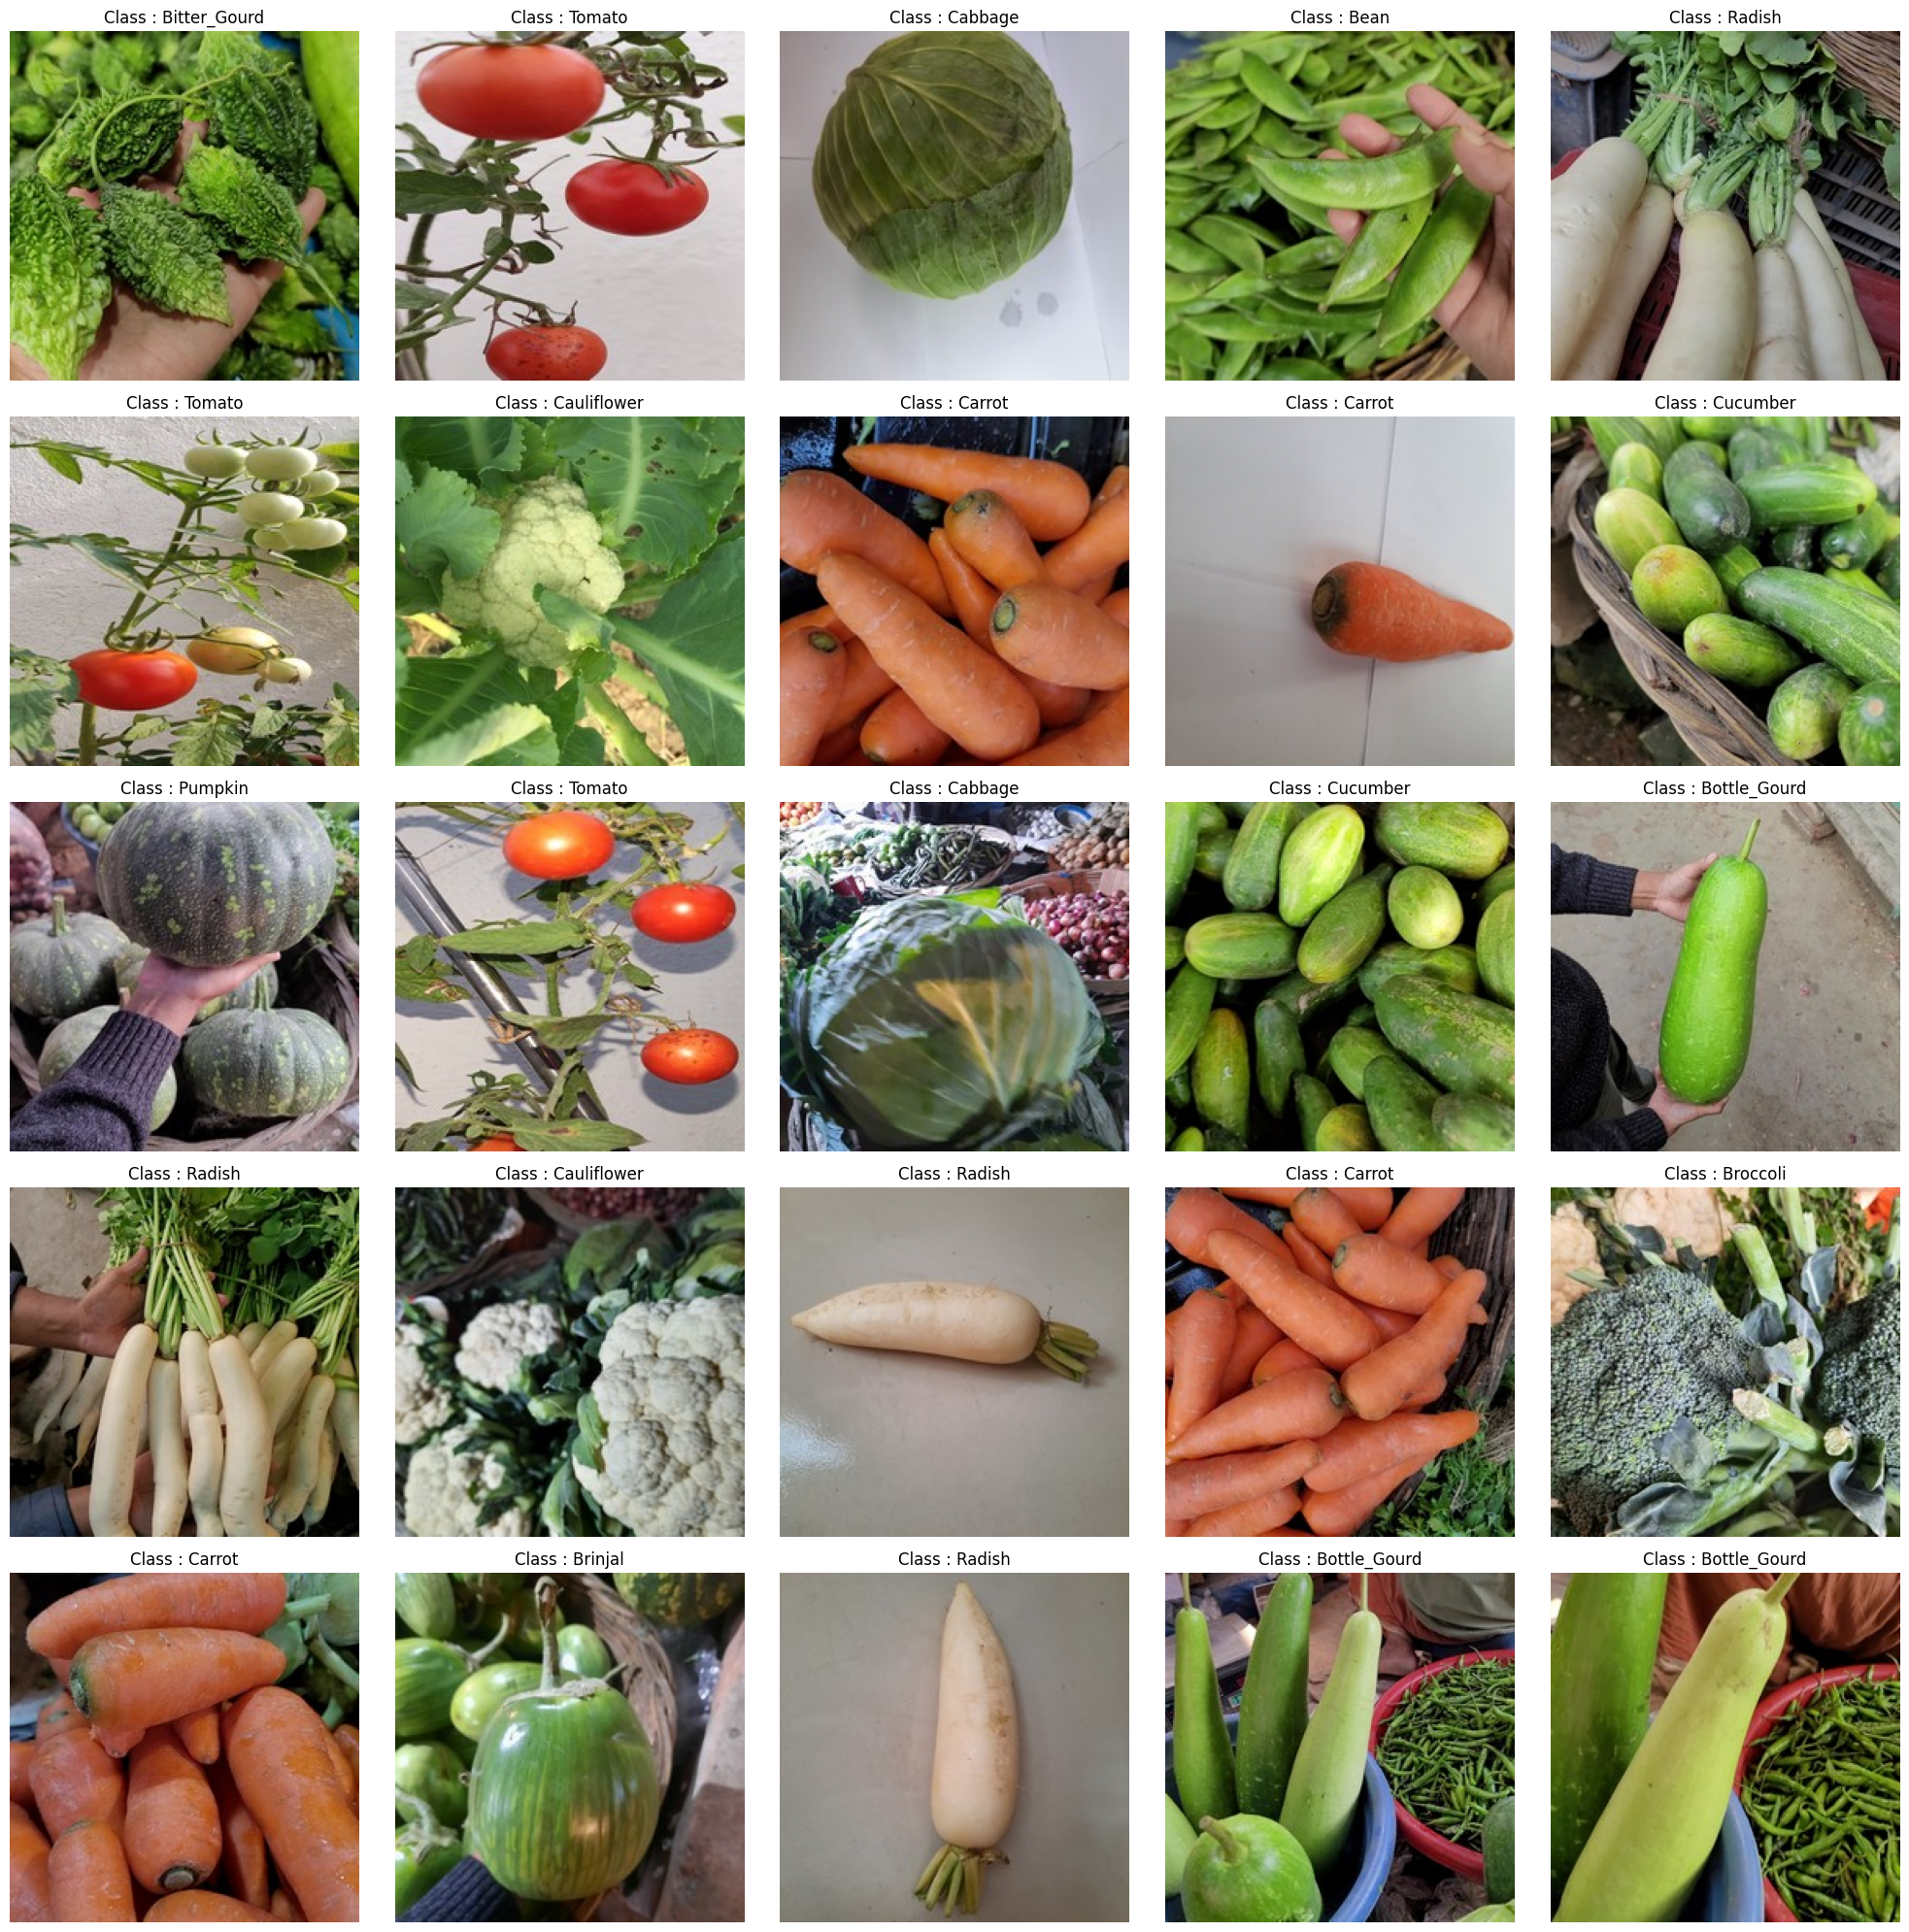

In [70]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_generator):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()
    
show_images()

In [47]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [48]:
# Model 1
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy",keras.metrics.Precision(), keras.metrics.Recall()])
print("Model parameters = %d" % model.count_params())
print(model.summary())

history_1 = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=callbacks_list)

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model parameters = 11635407
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 774400)            0         
                                                                 
 dropout (Dropout)           (None, 774400)            0         
                                                                 
 dense_13 (Dense)            (None, 15)                11616015  
                          

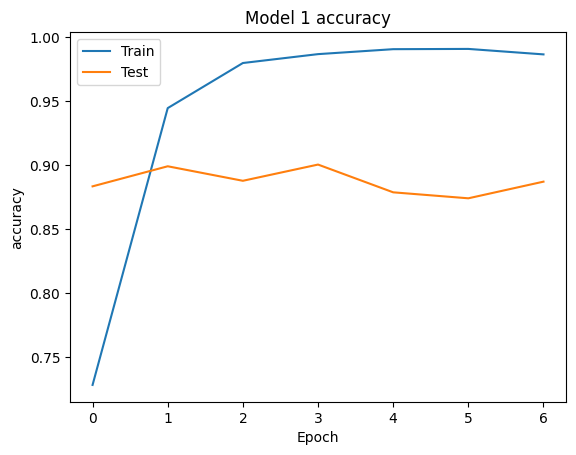

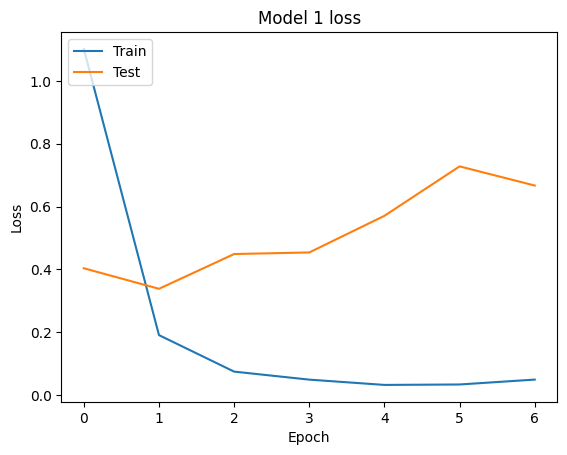

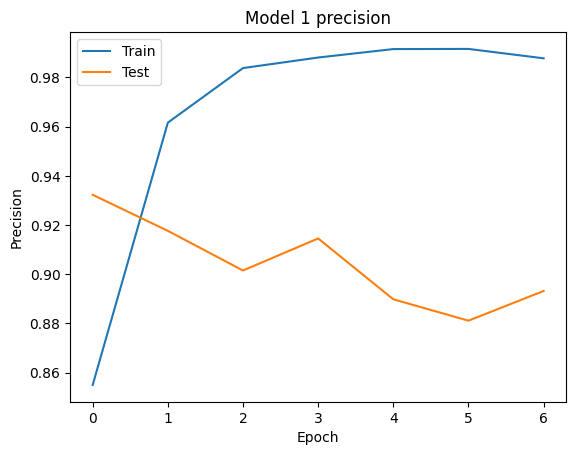

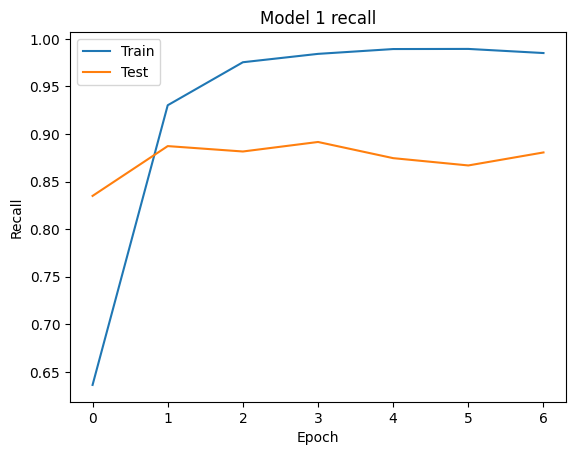

In [58]:
# Model 1 plots
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_1.history['precision_8'])
plt.plot(history_1.history['val_precision_8'])
plt.title('Model 1 precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_1.history['recall'])
plt.plot(history_1.history['val_recall'])
plt.title('Model 1 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [54]:
# Model 2
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

print(model.summary())

# Train the model with no data augmentation
history_2 = model.fit( train_generator_aug, epochs=30,
    validation_data=validation_generator, callbacks=callbacks_list)

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 flatten_9 (Flatten)         (None, 394272)            0         
                                                                 
 dense_17 (Dense)            (None, 15)                5914095   
                                                                 
Total params: 5,914,991
Trainable params: 5,914,991
Non-trainable params: 0
____________________________________________

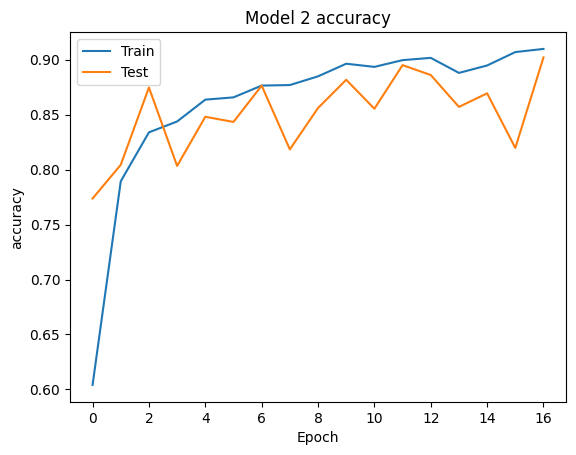

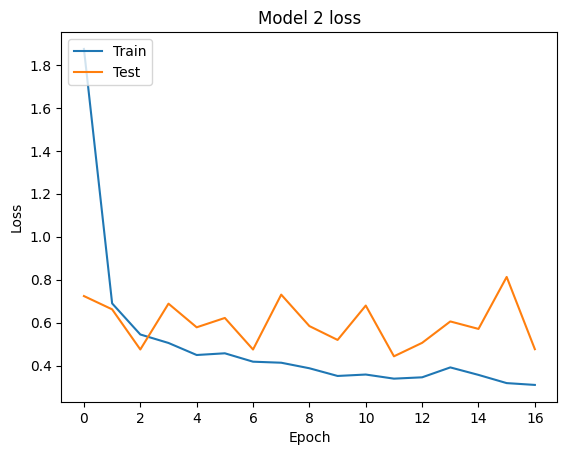

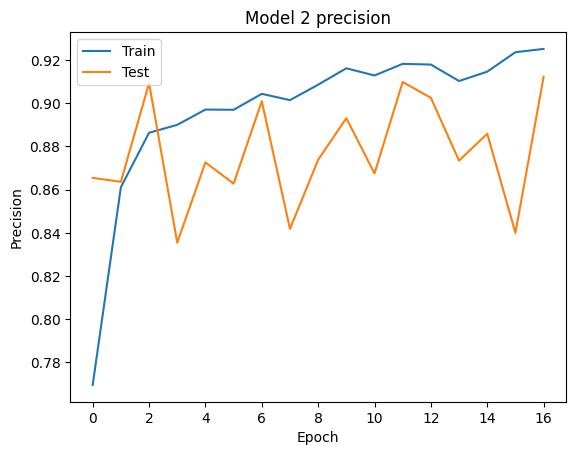

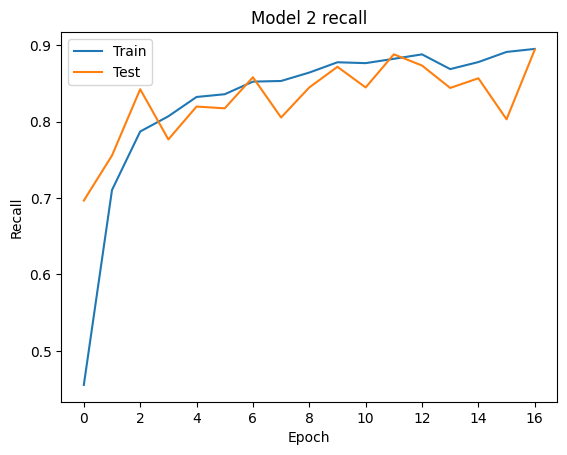

In [60]:
# Model 2 plots
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_2.history['precision_12'])
plt.plot(history_2.history['val_precision_12'])
plt.title('Model 2 precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_2.history['recall_4'])
plt.plot(history_2.history['val_recall_4'])
plt.title('Model 2 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy",keras.metrics.Precision(), keras.metrics.Recall()])

print(model.summary())

# Train the model with  data augmentation
history_resnet50 = model.fit( train_generator_aug, epochs=30,
    validation_data=validation_generator, callbacks=callbacks_list)

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 3, 3, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 18432)             0         
                                                                 
 dropout_4 (Dropout)         (None, 18432)             0         
                                                                 
 dense_18 (Dense)            (None, 15)                276495    
                                                                 
Total params: 23,864,207
Trainable params: 276,495
Non-trainable params: 23,587,712
___________________________________

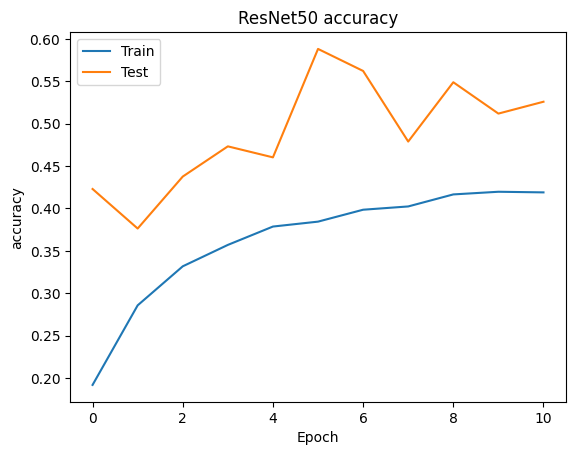

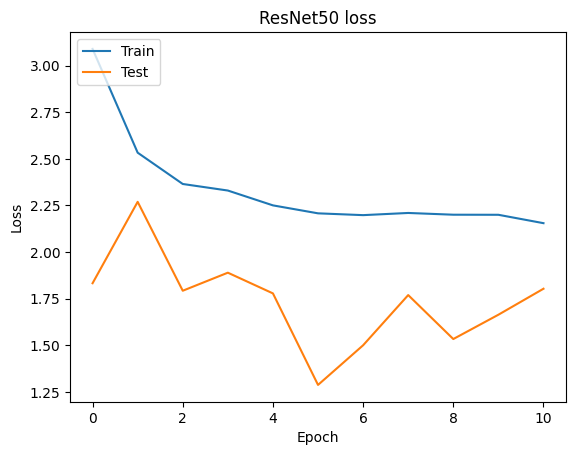

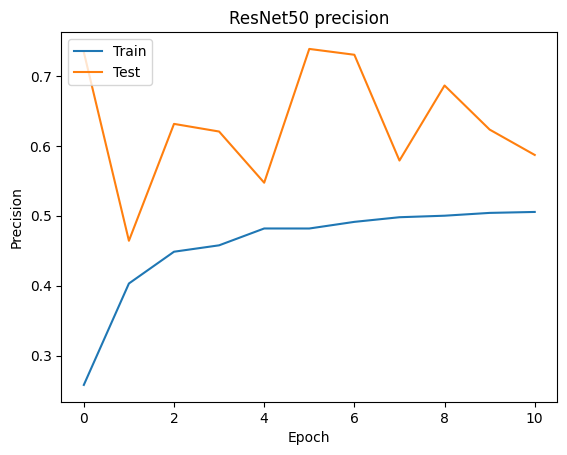

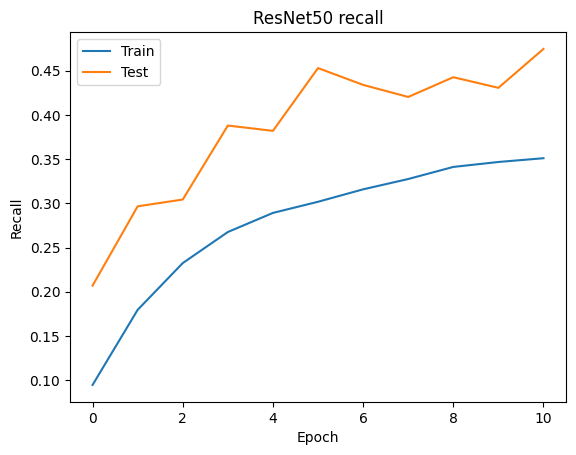

In [61]:
# ResNet50 plots
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('ResNet50 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('ResNet50 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_resnet50.history['precision_13'])
plt.plot(history_resnet50.history['val_precision_13'])
plt.title('ResNet50 precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_resnet50.history['recall_5'])
plt.plot(history_resnet50.history['val_recall_5'])
plt.title('ResNet50 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [56]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# Pre-Trained Model 
base_model = ResNet50V2(input_shape=(224,224,3), include_top=False)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# Model Compiling
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy",keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())

history_resnet50v2 = model.fit( train_generator_aug, epochs=30,
    validation_data=validation_generator, callbacks=callbacks_list)

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 3, 3, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 18432)             0         
                                                                 
 dropout_5 (Dropout)         (None, 18432)             0         
                                                                 
 dense_19 (Dense)            (None, 15)                276495    
                                                                 
Total params: 23,841,295
Trainable params: 276,495
Non-trainable params: 23,564,800
___________________________________

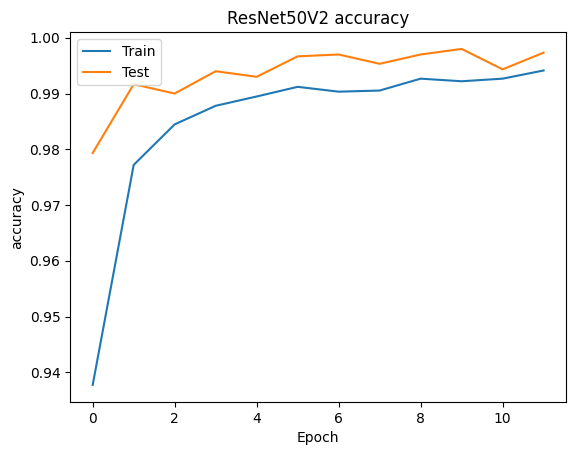

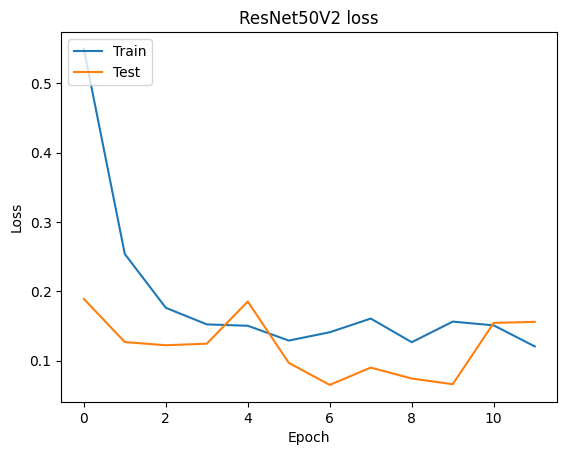

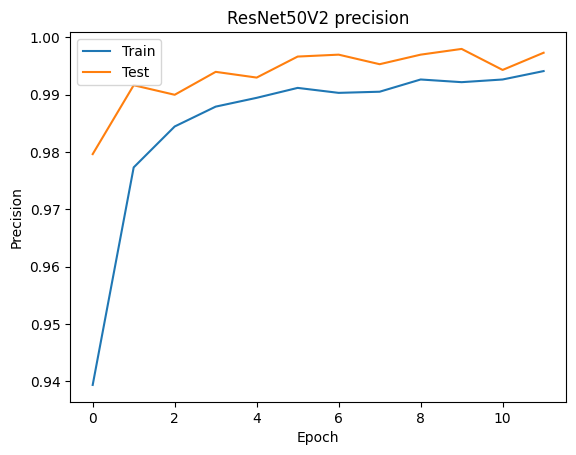

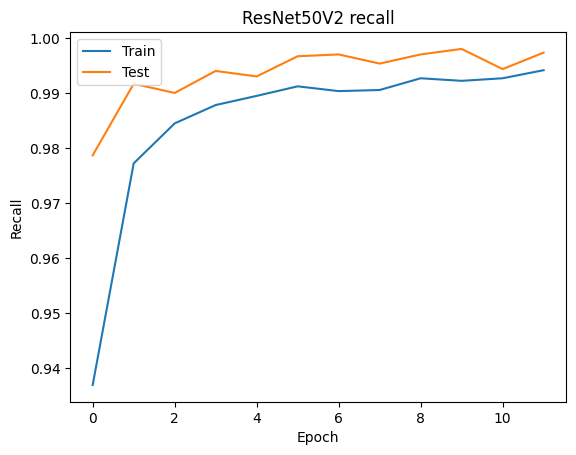

In [62]:
plt.plot(history_resnet50v2.history['accuracy'])
plt.plot(history_resnet50v2.history['val_accuracy'])
plt.title('ResNet50V2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_resnet50v2.history['loss'])
plt.plot(history_resnet50v2.history['val_loss'])
plt.title('ResNet50V2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_resnet50v2.history['precision_14'])
plt.plot(history_resnet50v2.history['val_precision_14'])
plt.title('ResNet50V2 precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_resnet50v2.history['recall_6'])
plt.plot(history_resnet50v2.history['val_recall_6'])
plt.title('ResNet50V2 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [102]:
# Model 3
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

print(model.summary())

# Train the model with no data augmentation
history_3 = model.fit( train_generator_aug, epochs=30,
    validation_data=validation_generator, callbacks=callbacks_list)

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 222, 222, 8)       224       
                                                                 
 conv2d_82 (Conv2D)          (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 110, 110, 8)      0         
 g2D)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 110, 110, 8)       0         
                                                                 
 flatten_42 (Flatten)        (None, 96800)             0         
                                                                 
 dense_58 (Dense)            (None, 15)                1452015   
                                                     

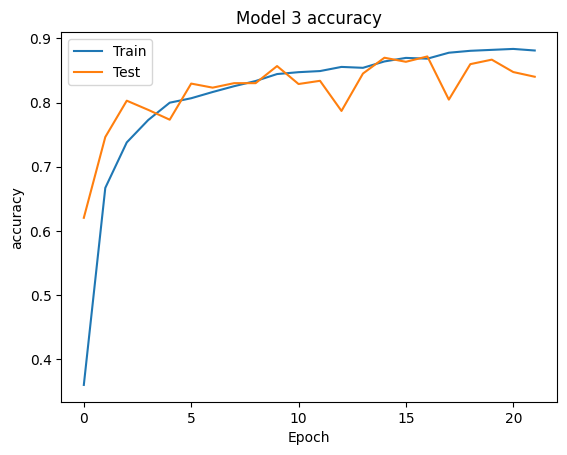

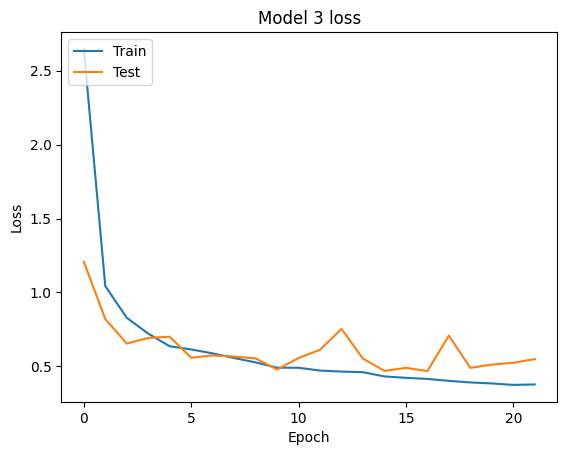

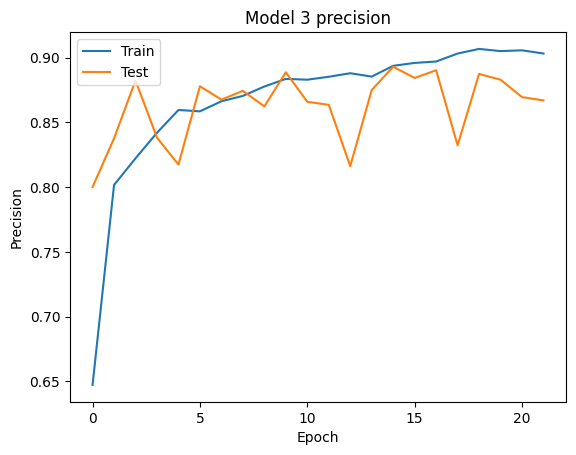

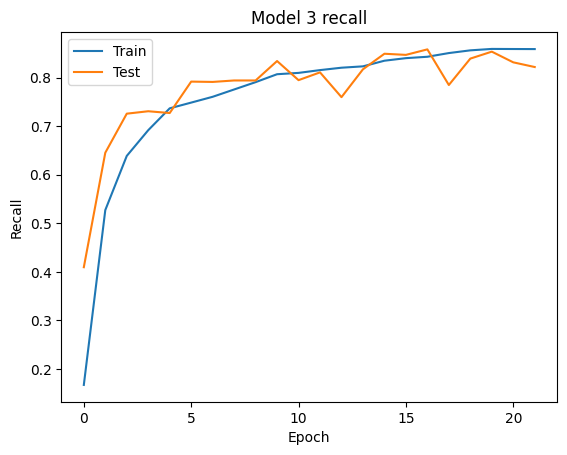

In [104]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_3.history['precision_45'])
plt.plot(history_3.history['val_precision_45'])
plt.title('Model 3 precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_3.history['recall_37'])
plt.plot(history_3.history['val_recall_37'])
plt.title('Model 3 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()